# HW02 Overview

Please complete all core assignment tasks. For 50% bonus points please complete the optional stretech assignment tasks that will involve more theory and programming.

## The assignments in this notebook require significant computational time to complete. 
* Students have reported anywhere from **3-4 hours** to perform the grid search
* Students have reported **an overnight (10+ hours)** to generate predictions on the full dataset (for a Kaggle submission). 
* Please __front-load your work__ and leave plenty of time to run your completed code.

## Please consult Canvas for the full grading rubric (check Module 02 -> HW 02).

The best approach is to work through this notebook. To cross-check your work, you can verify you have completed the sections marked "TASK:"

Broadly speaking you will be graded on the following:

* Download the data and preprocess the data
* Configure and perform a grid search over the specified range of hyperparameter settings
* Visualize the results of gridsearch and discuss the best model
* Report performance on the held-out test set; present a table of results (for the different models you build)
* For the optional tasks, you will need to review and complete the code provided.


__For your reference, following is the grading rubric from Canvas.__
* The homework is based on a total of 40 points (required tasks only).  
* The last two rows are optional, extra-credit assignments.

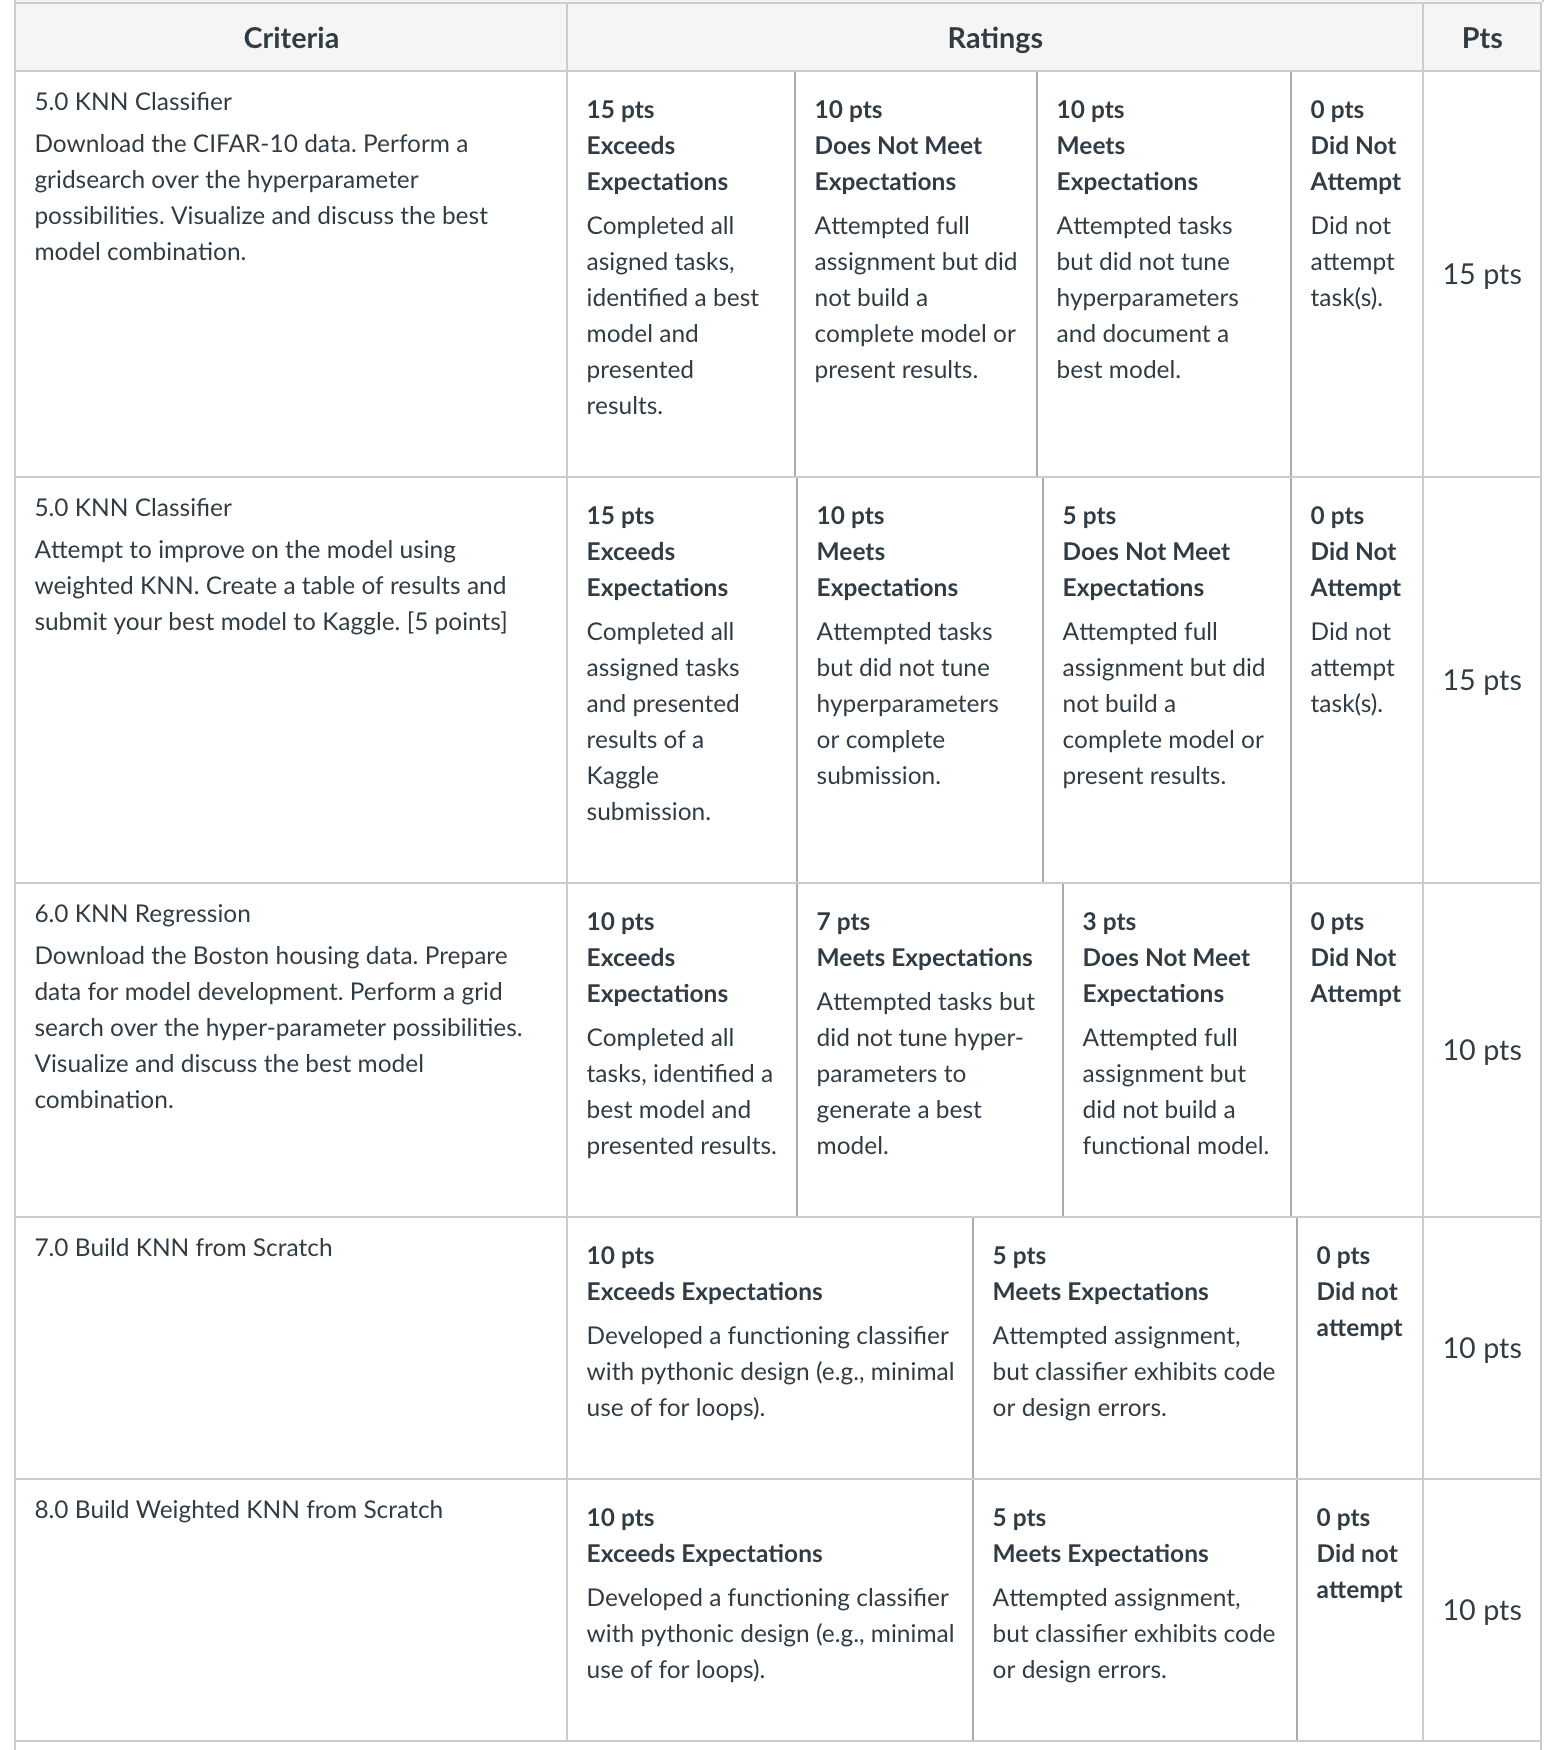

## Debugging reminder:

To start the debugger in a code cell cut and paste the following line of code where you want the debugger to stop or break. **Remember to use `q` to quit the debugger when you are finished!**

**`from IPython.core.debugger import Pdb as pdb;    pdb().set_trace() #breakpoint; dont forget to quit`**

The following commands can be used to operate the debugger:

* quit/q: type q  to quit and stop the programm execution
* cont/c: Continue to the next breakpoint
* next/n: Go to the next line
* pp/p: Pretty printing/printing a variable
* l: list the code surrounding the current line (where the debugger has stopped)
* step/s: step into a function
* help/h: Displays the list of commands

**Use the %debug magic to activate pdb after an error occurs.**

For example:

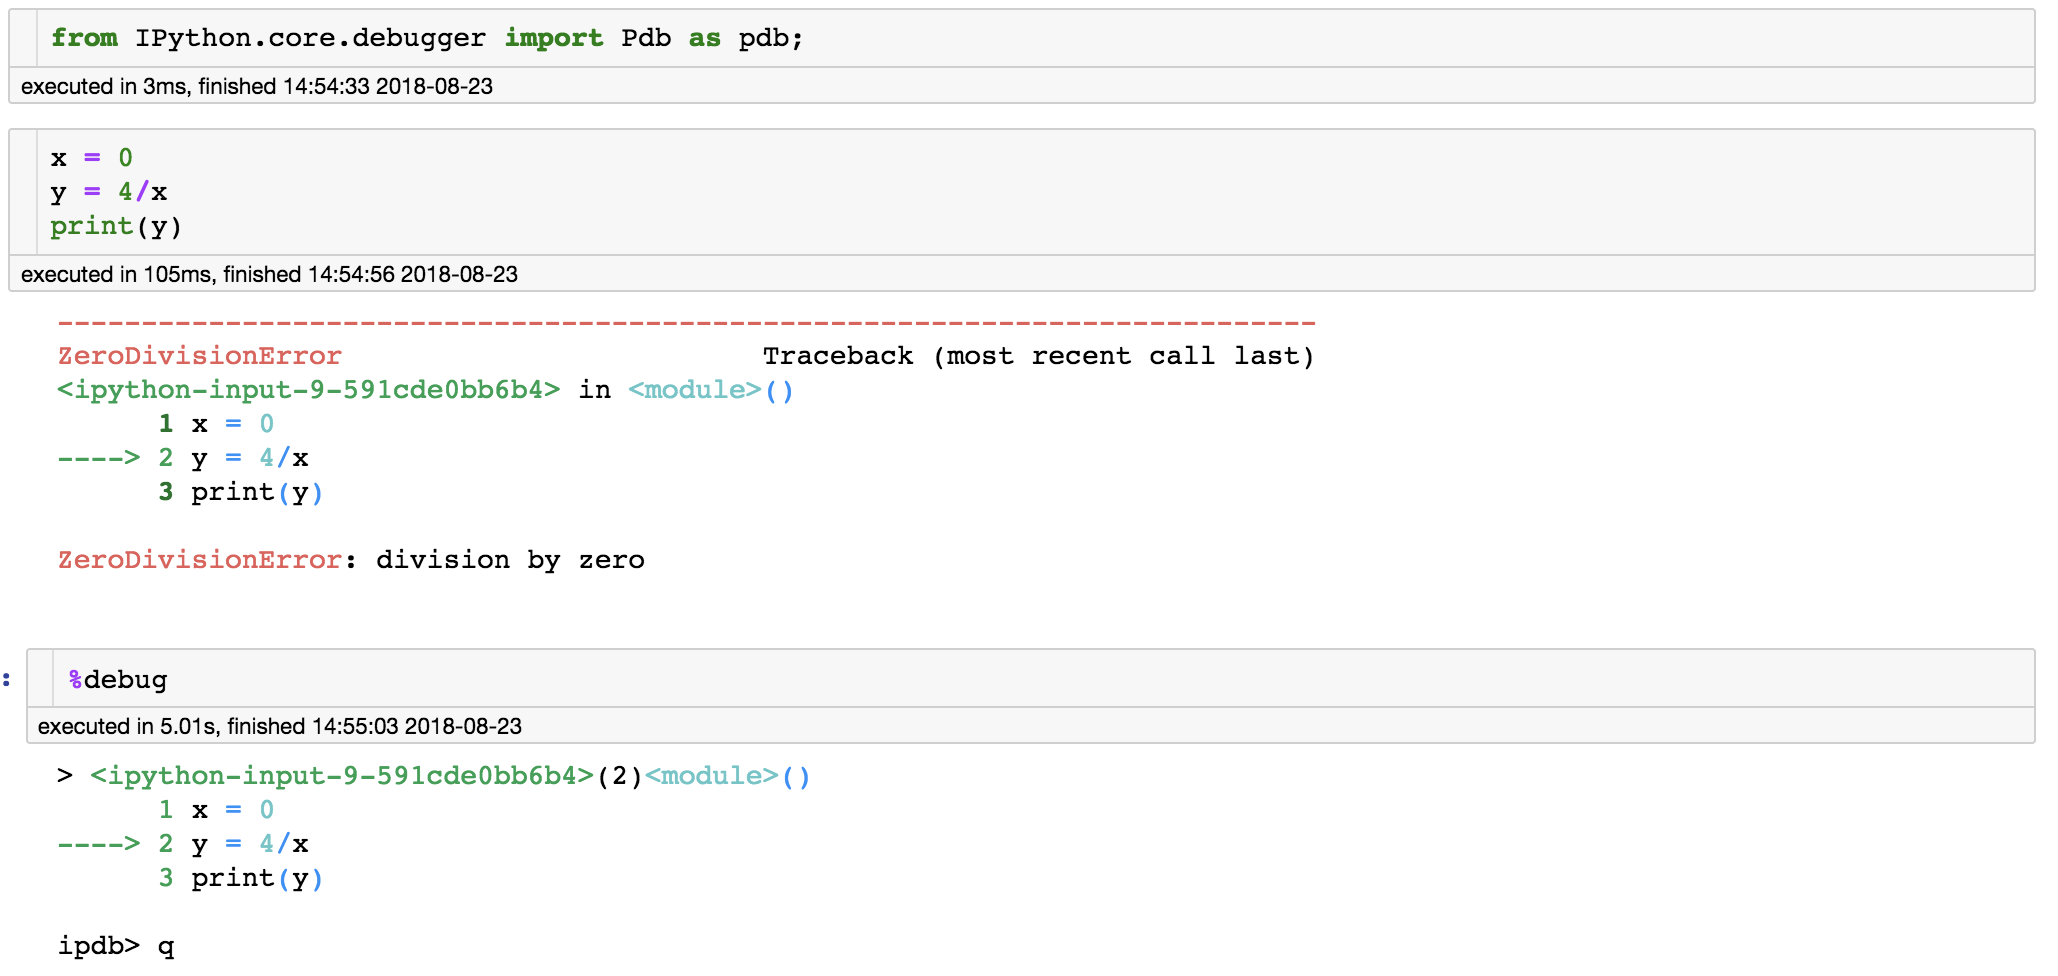

## Timing
A neat timing feature in jupyter:
* Go to the menu File -> Open, and select the NBExtensions TAB. 
* Click on the ExecuteTime option. 
* With this extension enabled, you will see when a cell was last executed and how much time it took to execute.


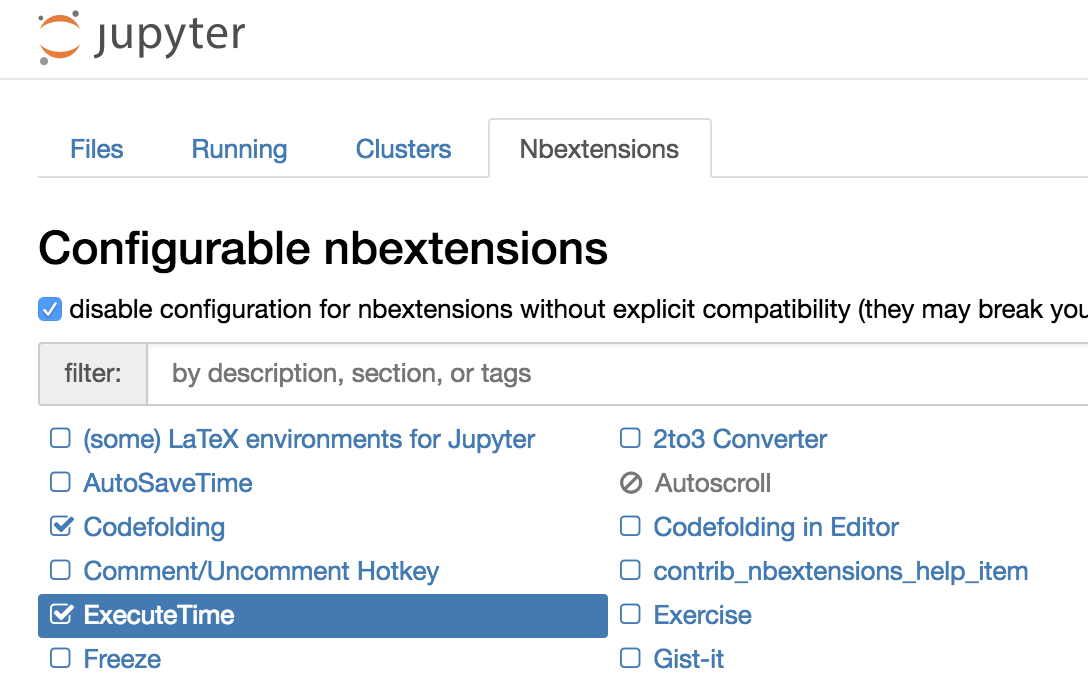

# Image classification dataset: CIFAR10

In this homework, we will be using a couple of datasets. The bigger one is this Image classification dataset: CIFAR10.

The [CIFAR-10](http://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks. Such a situation is called **multiclass** classification in oppose to **multilabel** classification when each example may have multiple label.

One can see state-of-the-art results [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html)

## Prepare the notebook

In [43]:
from IPython.core.debugger import Pdb as pdb
import _pickle as cPickle
import tarfile

import numpy as np
import pandas as pd

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Set style for plotting

In [44]:
sns.set(style="whitegrid", font_scale=1.3)
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True

## Set a random seed for reproducibility

In [45]:
np.random.seed(42)

# Upack the Data and do EDA (exploratory data analysis)
In this section we unpack the CIFAR-10 Data set and do some exploratory data analysis

Before you proceed:
* DOWNLOAD the image data from [HERE](http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) 
* PUT IT in the data folder insider the Unit-02_KNN_CIFAR10 folder

Unarchive data

In [46]:
tar = tarfile.open("data/cifar-10-python.tar.gz", "r:gz")
tar.extractall("data")
tar.close()

## Load the data

Data are stored as a memory dump with python $\text{dict}$ object. It was created using **pickle** function. To read one should "unpickle" it.

In [47]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo, encoding='latin1')
    fo.close()
    return dict

Data are also splitted in to 5 pieces for conveniece. Let's read them all and concatenate

In [48]:
for b in range(1, 6):
    data_batch = unpickle("data/cifar-10-batches-py/data_batch_" + str(b))
    if b == 1:
        X_train = data_batch["data"]
        y_train = np.array(data_batch["labels"])
    else:
        X_train = np.append(X_train, data_batch["data"], axis=0)
        y_train = np.append(y_train, data_batch["labels"], axis=0)

Read test data. In this dataset train/test split is provided by authors of the dataset to be able to consistently evaluate solutions

In [49]:
data_batch = unpickle("data/cifar-10-batches-py/test_batch")
X_test = data_batch["data"]
y_test = np.array(data_batch["labels"])

Read meta-information file with the names of the classes

In [50]:
classes = unpickle("data/cifar-10-batches-py/batches.meta")["label_names"]

## Data engineering (pre-processing)

We have too many data

In [51]:
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 50000
Test size: 10000


### Downsample the data so we can experiment more easily
Let's downsample (common strategy to get a POC, proof of concept working) the data by taking a random sample of 10% the training and test sets. This will  allow us to do some experiments much more quickly. 

**DO NOT FORGET to use all the data when you perform your Kaggle submissions later in the assignment**.

In [52]:
subsample_rate = 0.1

We want to preserve the same quantity ratio between classes. In python such an option is called **stratification**. Let's randomly (with fixed initial seed for the sake of reproducibility) divide part of train data

In [53]:
X_train, _, y_train, _ = train_test_split(X_train, y_train, stratify=y_train, train_size=subsample_rate, random_state=42)

C:\Users\hv158\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


The same for test

In [54]:
X_test, _, y_test, _ = train_test_split(X_test, y_test, stratify=y_test, train_size=subsample_rate, random_state=42)

C:\Users\hv158\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Indeed, we preserved the number of objects of each class

In [55]:
unique_train = np.unique(y_train, return_counts=True)
list(zip(np.array(classes)[unique_train[0]], unique_train[1]))

[('airplane', 500),
 ('automobile', 500),
 ('bird', 500),
 ('cat', 500),
 ('deer', 500),
 ('dog', 500),
 ('frog', 500),
 ('horse', 500),
 ('ship', 500),
 ('truck', 500)]

## Understand the data

For now each object has the following shape

In [56]:
X_train[0].shape

(3072,)

$3072 = 32 \times 32 \times 3$ where $32 \times 32$ is the size of the image in pixels and $3$ is the number of channels (RGB)

To show this array as an image let's reshape it in the needed from with the shape $(32, 32, 1)$

In [57]:
def show_pic(x):
    plt.imshow(x.reshape((3, 32, 32)).transpose(1, 2, 0).astype("uint8"))
    plt.axis("off")

Draw one pic from each class

In [58]:
classes_idx_examples = np.zeros(10, dtype=np.int)
for i in range(10):
    classes_idx_examples[i] = np.where(y_train == i)[0][0]

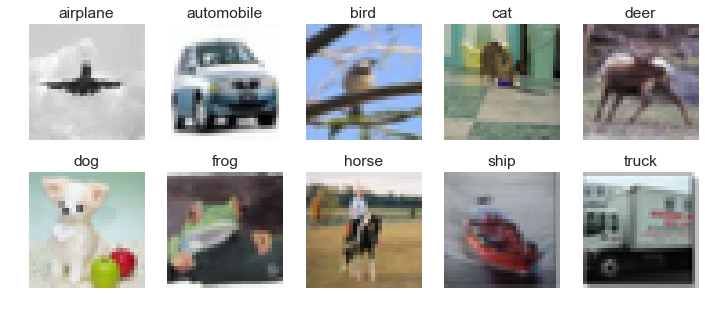

In [59]:
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_pic(X_train[classes_idx_examples[i]])
    plt.title(classes[i])

# Modeling: build a model using sci-kit learn

Let's use Sklearn implementation of algorithms to build some benchmark models for image classification.

Also one should **always** track the results of the experiments to be able to compare different approaches. Let's create pandas $\text{DataFrame}$ for this purpose.

In [60]:
results = pd.DataFrame(columns=["Model", "Test Accuracy"])

For now it is empty, but will be filled in later

In [61]:
results

,Model,Test Accuracy


## KNN

In this section the K Nearest Neighbors implementation from sklearn is presented (see theory below and in lectures)

For the beginning let's use default parametrs of KNN Sklearn classifier which are:
* $\text{n_neighbors} = 5$
* $L_2$ metric

In [62]:
# n_jobs is responsible for number of CPU cores used for computation
# -1 means use all available
model_knn_sklearn = KNeighborsClassifier(n_jobs=-1)

### Fitting

In [63]:
model_knn_sklearn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform')

### Evaluation

Predict answers on the test set

In [64]:
y_pred_test = model_knn_sklearn.predict(X_test)

Accuracy score with sklearn function

In [65]:
acc = accuracy_score(y_test, y_pred_test)

Append first row to the results table

In [66]:
results.loc[len(results)] = ["KNN Arbitary Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262


### Insight into predictions

Let's take one correct prediction from test set and look onto its nearest neighbors

In [67]:
correct_idx = np.where(y_pred_test == y_test)[0][0]

Get $k$ nearest neighbors via Sklearn interface (method $\text{kneighbors}$)

In [68]:
neighbors = model_knn_sklearn.kneighbors(X=[X_test[correct_idx]], return_distance=False)[0]

Let's see what examples are

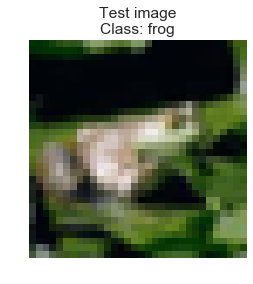

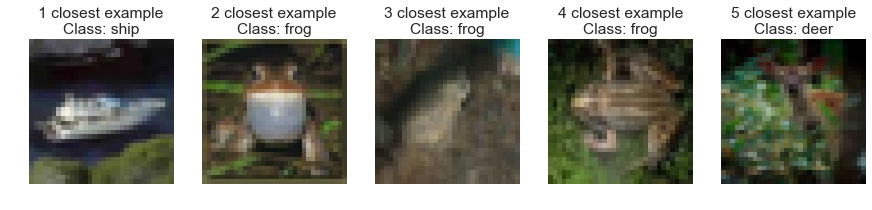

In [69]:
show_pic(X_test[correct_idx])
plt.title("Test image\nClass: " + classes[y_test[correct_idx]])
plt.show()
plt.figure(figsize=(15, 3))
for i, neighbor_idx in enumerate(neighbors):
    plt.subplot(1, 5, i + 1)
    show_pic(X_train[neighbor_idx])
    plt.title(str(i + 1) + " closest example\nClass: " + classes[y_train[neighbor_idx]])
plt.show()

Indeed, among five closest objects we have three frogs and ship pic which is very close to the initial frog pic.

It's **good** even the accuracy is bad, because our model can be explained in a very **intuitive** way

## Logistic Regression

We compare our KNN model to a model based on Multinomial Logistic Regression.
* We will learn more about this in a coming lecture.  For now, treat this as a black box classification approach.

Here we used Sklearn $\text{SGDClassifier}$ with few options:
* $\text{loss} = \text{"log"} -$corresponds to Logistic Regression
* $\text{penalty} = \text{"none"}-$ for now we don't want to use regularization (using it should impove quality by few percents)
* $\text{max_iter} = 15 -$ the number of passes over the training data (aka epochs)
* $\text{average} = 10 -$ by default Stochastic Gradient Descent method is used. This is due to the not very good approximation of gradient (only by one example). To neglect this error we simply average gradient across last 10 steps.

In [70]:
model_lr_sklearn = SGDClassifier(loss="log", penalty="none", max_iter=15, average=10, n_jobs=-1)

### Fitting

In [71]:
model_lr_sklearn.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=10, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=15, n_iter=None,
       n_jobs=-1, penalty='none', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

### Evaluation

Prediction

In [72]:
y_pred_test = model_lr_sklearn.predict(X_test)

Accuracy

In [73]:
acc = accuracy_score(y_test, y_pred_test)

Keeping table of results up-to-date

In [74]:
results.loc[len(results)] = ["LR Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.338


$7\%$ better, not bad!

# Core (Required) Assignment

In order to complete this lab successfully, please review the following lab:
* `CrossvalidationAndGridSearch-Tutorial.ipynb` from Unit 02 Labs folder.


**REMEMBER to use all of the CIFAR-10 data for Kaggle submissions (we are using only 10% of the data for experimentation)**.

In [75]:
print("Train X size:", X_train.shape)
print("Train y size:", y_train.shape)

Train X size: (5000, 3072)
Train y size: (5000,)


## K Nearest Neighbors: Grid Search
Using the CIFAR-10 dataset and the built-in Sklearn implementation of KNN classifier, find the best set of parameters from the following range:

$$
\text{n_neighbors} \in \{1 \ldots 5\}\\
\text{p} \in \{1 \ldots 3\}
$$

where $\text{n_neighbors}$ is the number of neighbors to consider and $\text{p}$ is the order of $L_p$ metric (see explanation below)


### TASK: Sklearn  GridSearch with Cross Validation
You will need to complete the code in this section to perform a hyperparameter tuning via SKLearn's `GridSearchCV`.  Perform a grid search over the training set only. The test dataset should only be used to report your findings after you have committed to your best model(s).

In [76]:
knn_sk = KNeighborsClassifier(n_jobs=-1)

And specify the dictionary of parameters we want to optimize along with their ranges

In [77]:
n_neighbors_range = [1,2,3,4,5]
p_range = [1,2,3]
parameters = {'n_neighbors': n_neighbors_range, 'p': p_range}

$\text{GridSearchCV}$ function does all the stuff. There are three main arguments:
* $\text{estimator} = \text{knn_sk} -$classifier to use; KNN from sklearn defined before
* $\text{param_grid} = \text{parameters} -$parameters ranges to test
* $\text{cv} = \text{split} -$splitting iterator to use

In [78]:
%%time
best_model = GridSearchCV(estimator=knn_sk, 
                          param_grid=parameters,  
                          cv=3, 
                          refit=False,  
                          return_train_score=False)
best_model.fit(X_train, y_train)

Wall time: 18min 30s


Let's retrieve best parameters

In [79]:
best_p = best_model.best_params_["p"]
best_n = best_model.best_params_["n_neighbors"]

### best_model.cv_results_ holds a lot of useful information

Please have a closer look at the results dictionary:

* best_model.cv_results_["param_n_neighbors"]                
* best_model.cv_results_["param_p"]
* best_model.cv_results_["mean_test_score"] 


In [80]:
# have a look at CV dictionary of results
best_model.cv_results_

{'mean_fit_time': array([0.596373  , 0.58339739, 0.56775641, 0.56256398, 0.58339143,
        0.56242315, 0.56778312, 0.58339771, 0.57284339, 0.5729444 ,
        0.58339858, 0.57288575, 0.56257033, 0.58861478, 0.55716538]),
 'std_fit_time': array([0.02876949, 0.01473403, 0.0147096 , 0.01274453, 0.00737284,
        0.00021608, 0.01949305, 0.00739521, 0.00727929, 0.01955301,
        0.00738329, 0.01479287, 0.01274891, 0.00735   , 0.00754027]),
 'mean_score_time': array([ 4.76323199,  4.45373567, 62.19831204,  3.90664681,  3.99523624,
        63.83498295,  3.89627282,  3.984828  , 64.70489812,  3.9431564 ,
         3.99001153, 64.63188187,  3.87541493,  4.06825606, 65.11124086]),
 'std_score_time': array([0.22801428, 0.47635244, 0.19272797, 0.10205448, 0.00735957,
        0.6222949 , 0.05158231, 0.04599061, 0.83117229, 0.0265743 ,
        0.03210551, 0.64890912, 0.0460312 , 0.00750879, 0.01935853]),
 'param_n_neighbors': masked_array(data=[1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5],
    

In [81]:
#best_model.cv_results_["param_n_neighbors"],        
#best_model.cv_results_["param_p"], 
best_model.cv_results_["mean_test_score"], 

(array([0.2858, 0.2652, 0.2438, 0.2514, 0.2402, 0.2162, 0.283 , 0.2596,
        0.2394, 0.2924, 0.2666, 0.2402, 0.3008, 0.2634, 0.251 ]),)

### TASK: Report any interesting aspect of best_model
Please report and discuss any interesting aspect of best_model dictionary (there is no wrong or right response here, but you must practice discussing your results).

{'n_neighbors': 3, 'p': 1} This is the best estimator parameters for KNNClassifier in this experiment.
We can see from the graph that Classifier works best with odd number of neighbors i.e. 1,3,5.... This is because there could be more chances of tie condition for even number of neighbors.
Also we see that Classifier works bets here with p=1 i.e. Manhattan distances.

### Visualize the performance metrics along each hyperparemter
Next please visualize the accuracy for each pair of parameters (Number of neighbors and $p$) as follows [Note the code cell below will help accomplish this]:

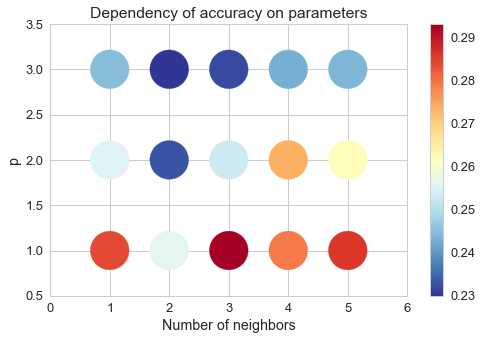

C:\Users\hv158\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


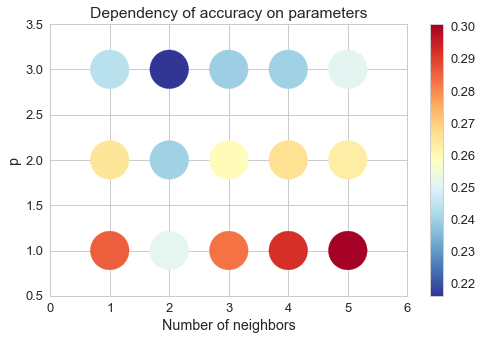

In [82]:
plt.figure(figsize=(8, 5))
sc = plt.scatter(best_model.cv_results_["param_n_neighbors"], 
                 best_model.cv_results_["param_p"], 
                 c=best_model.cv_results_["mean_test_score"], 
                 cmap = plt.get_cmap("RdYlBu_r"), 
                 s=1500)
plt.colorbar(sc)
plt.grid("on")
plt.gca().set_axisbelow(True)
plt.xlabel("Number of neighbors")
plt.ylabel("p")
plt.title("Dependency of accuracy on parameters")
plt.xlim([0, 6])
plt.ylim([0.5, 3.5]);

Let's choose the best $p^*$ and see how accuracy depends on the number of nearest neightbors for a KNN classifier  $p$

In [83]:
p_idx = best_model.cv_results_["param_p"].data == best_p

C:\Users\hv158\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


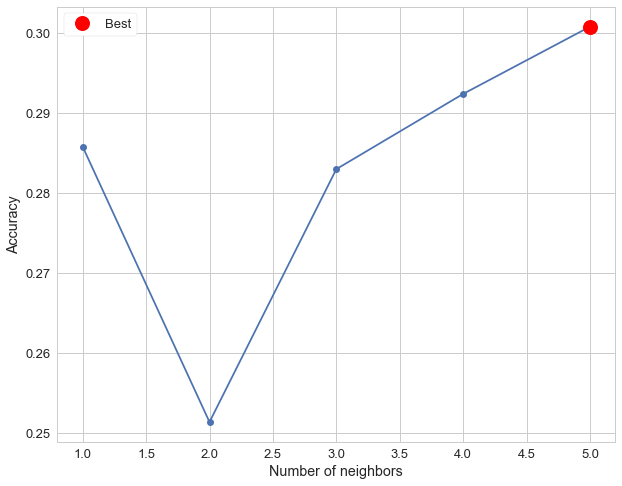

In [84]:
plt.figure(figsize=(10, 8))
plt.plot(best_model.cv_results_["param_n_neighbors"].data[p_idx], 
         best_model.cv_results_["mean_test_score"][p_idx], 
         "o-")
plt.plot([best_n], [best_model.cv_results_["mean_test_score"][p_idx][best_n - 1]], "or", markersize=15, label="Best")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.title("")
plt.grid("on")
plt.legend(numpoints=1)
plt.show()

Let's add this result to the table of results.  Get in the practice of always keeping a table of results.

In [85]:
acc = best_model.best_score_

In [86]:
results.loc[len(results)] = ["KNN Grid Search Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.338
2,KNN Grid Search Sklearn,0.301


### Sklearn Weighted KNN
In usual KNN every object from $k$ nearest neighbors is treated equally (it is called **majority voting**). But it is obvious that closer object should make bigger impact.

In this section you should not code anything again. Just see.

In [87]:
model_knn_weighted_sklearn = KNeighborsClassifier(n_jobs=-1, weights="distance", p=1, n_neighbors=3)

In [88]:
model_knn_weighted_sklearn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=1,
           weights='distance')

In [89]:
y_pred_test = model_knn_weighted_sklearn.predict(X_test)

In [90]:
acc = accuracy_score(y_test, y_pred_test)

In [91]:
results.loc[len(results)] = ["KNN Weighted Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.338
2,KNN Grid Search Sklearn,0.301
3,KNN Weighted Sklearn,0.304


You can see that the result is the better (by $1\%$) than simple KNN with Grid Search. 

### TASK - Grid search on _weighted_ KNN.
Perform a grid search over the same hyperparameters (n_neighbors and p) using weighted KNN to see if you can improve. Please add the accuracy of your best model on the test set in the table of results.

In [92]:
knn_weighted_sklearn = KNeighborsClassifier(n_jobs=-1, weights="distance")
n_neighbors_range = [1,2,3,4,5]
p_range = [1,2,3]
parameters = {'n_neighbors': n_neighbors_range, 'p': p_range}

In [93]:
%%time
best_model_weighted = GridSearchCV(estimator=knn_weighted_sklearn, 
                          param_grid=parameters,  
                          cv=3, 
                          refit=False,  
                          return_train_score=False)
best_model_weighted.fit(X_train, y_train)

Wall time: 18min 35s


In [94]:
best_p = best_model_weighted.best_params_["p"]
best_n = best_model_weighted.best_params_["n_neighbors"]

In [95]:
best_model_weighted.cv_results_

{'mean_fit_time': array([0.5782009 , 0.59383678, 0.5676825 , 0.56255325, 0.57298668,
        0.56775498, 0.57300433, 0.57297444, 0.56774886, 0.54695813,
        0.57821083, 0.56772526, 0.53653709, 0.57820408, 0.57294941]),
 'std_fit_time': array([1.27407292e-02, 1.27446192e-02, 7.42711986e-03, 1.27574699e-02,
        7.34996174e-03, 7.39733125e-03, 1.94835730e-02, 1.94596563e-02,
        1.95068642e-02, 1.27704214e-02, 2.31940966e-05, 1.95063005e-02,
        1.95118678e-02, 1.27724593e-02, 7.32139570e-03]),
 'mean_score_time': array([ 3.96919664,  4.03691761, 63.96522864,  3.90667558,  4.01608968,
        64.79332081,  3.90667947,  4.00044433, 64.54848369,  3.88584367,
         3.99520795, 65.17354417,  3.9118673 ,  4.02649228, 65.08499146]),
 'std_score_time': array([5.84780339e-02, 1.47248726e-02, 2.92771897e-01, 1.04432942e-01,
        3.82753213e-02, 4.93560750e-01, 3.37653764e-02, 2.72648669e-05,
        2.45210351e-01, 7.35916128e-03, 3.89845258e-02, 7.01639427e-01,
        6.421

C:\Users\hv158\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


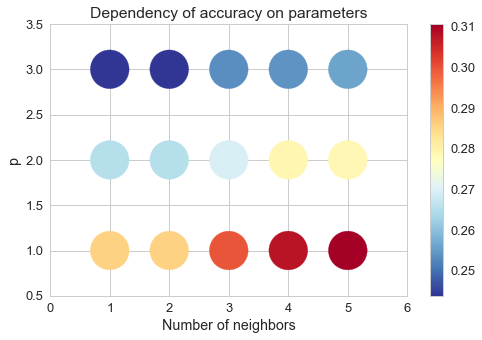

In [96]:
plt.figure(figsize=(8, 5))
sc = plt.scatter(best_model_weighted.cv_results_["param_n_neighbors"], 
                 best_model_weighted.cv_results_["param_p"], 
                 c=best_model_weighted.cv_results_["mean_test_score"], 
                 cmap = plt.get_cmap("RdYlBu_r"), 
                 s=1500)
plt.colorbar(sc)
plt.grid("on")
plt.gca().set_axisbelow(True)
plt.xlabel("Number of neighbors")
plt.ylabel("p")
plt.title("Dependency of accuracy on parameters")
plt.xlim([0, 6])
plt.ylim([0.5, 3.5]);

We can see here that  {'n_neighbors': 5, 'p': 1} works best here.
Also the accuracy gradually increases as we go from n=1 to n=5.
Interesting observation is for KNNClassifier n=3 was best whereas for Weighted KNNClassifier n=5 is best for the same set of data.

In [97]:
acc = best_model_weighted.best_score_
results.loc[len(results)] = ["TASK KNN Grid Search Sklearn", np.round(acc, 3)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.338
2,KNN Grid Search Sklearn,0.301
3,KNN Weighted Sklearn,0.304
4,TASK KNN Grid Search Sklearn,0.311


C:\Users\hv158\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


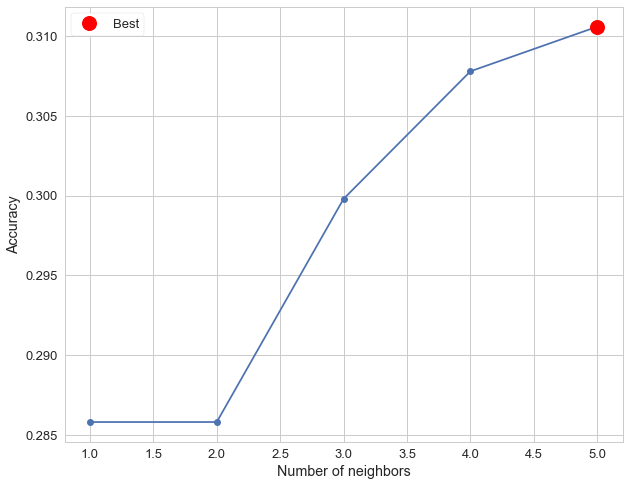

In [98]:
p_idx = best_model_weighted.cv_results_["param_p"].data == best_p
plt.figure(figsize=(10, 8))
plt.plot(best_model_weighted.cv_results_["param_n_neighbors"].data[p_idx], 
         best_model_weighted.cv_results_["mean_test_score"][p_idx], 
         "o-")
plt.plot([best_n], [best_model_weighted.cv_results_["mean_test_score"][p_idx][best_n - 1]], "or", markersize=15, label="Best")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.title("")
plt.grid("on")
plt.legend(numpoints=1)
plt.show()

## TASK - Do a submission to the Kaggle competition on [CIFAR](https://www.kaggle.com/c/cifar-10). 

Note that the training set in the competition is exactly the same as in this homework.  To discourage certain forms of cheating (such as hand labeling) Kaggle added 290,000 junk images in its test set. These images are ignored in the scoring, but you will need to predict labels for all 300,000 images. 

You can download the Kaggle test dataset from [this site](https://www.kaggle.com/c/cifar-10/data) in the file called test.7z. You must extract the images from this file using a .7z extractor of your choice. 

Also, do not forget to use all the CIFAR-10 data for your Kaggle submissions (previously we used just 10% of the data for experimentation).

Report your nick, rank and quality in this notebook when submitting an assignment solution. Include a screenshot of your relative position on the scoreboard. ** Please note that KNN is a poor performer on this task.**

For example:

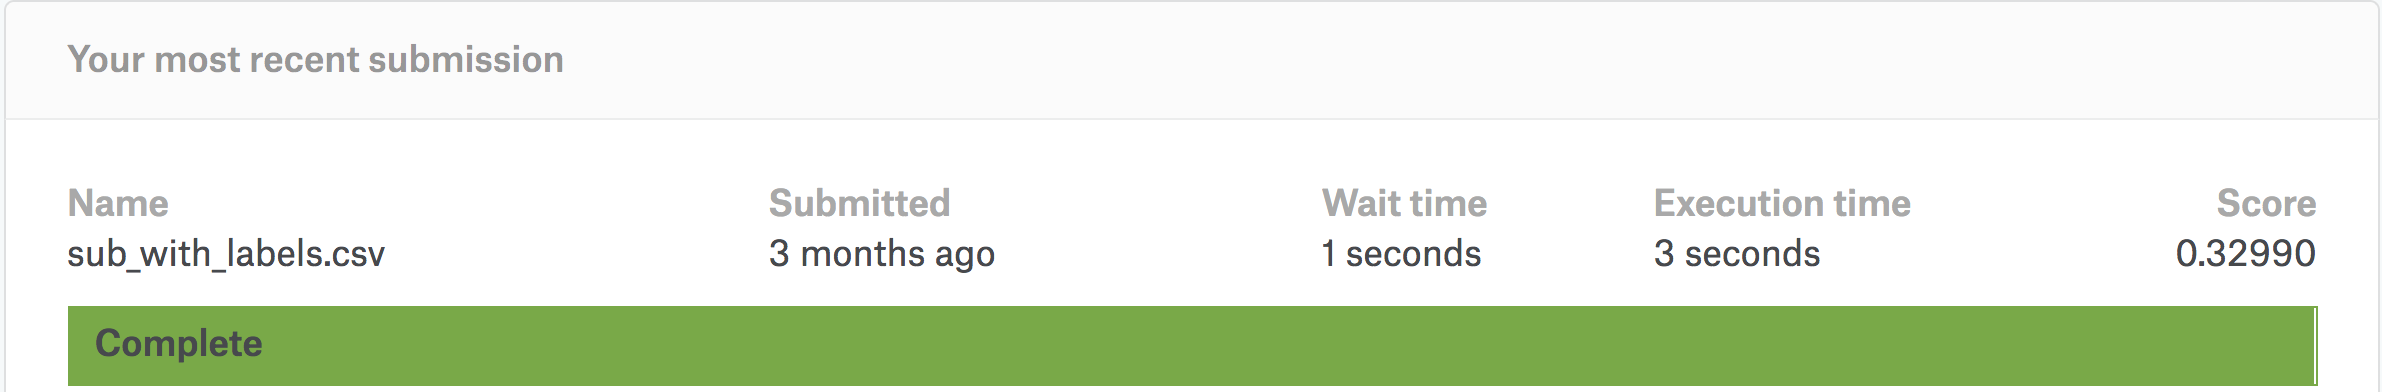

Converting the folder of PNG images to a single numpy array (with each image flattened into one row) requires some manipulation.  The sample code below will perform this task for you.  NOTE: To use this sample code without modification, the PNG image files must be located in a subdirectory of your current working directory called data/test.

(300000, 3072)

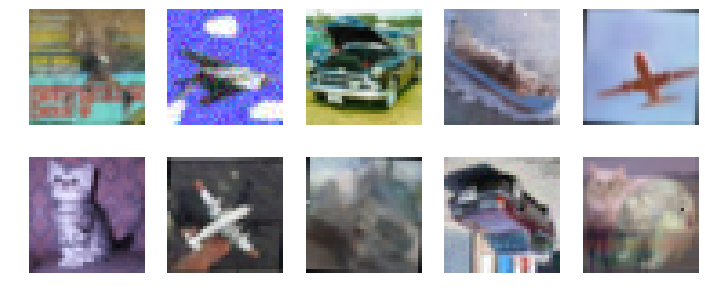

In [99]:
from matplotlib.pyplot import imread

# load image data
X_test = []
for n in range(1,300001):
    file = './data/test/test/'+str((n))+'.png'
    X_test.append(imread(file).transpose(2,0,1)*255)
X_test = np.array(X_test).reshape(len(X_test),-1)

# view first 10 images
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    show_pic(X_test[i])
    
X_test.shape # we should have 300000 images with 3072 features (32,32,3).

In [100]:
for b in range(1, 6):
    data_batch = unpickle("data/cifar-10-batches-py/data_batch_" + str(b))
    if b == 1:
        X_train_all = data_batch["data"]
        y_train_all = np.array(data_batch["labels"])
    else:
        X_train_all = np.append(X_train_all, data_batch["data"], axis=0)
        y_train_all = np.append(y_train_all, data_batch["labels"], axis=0)

In [101]:
print("Train X size:", X_train_all.shape)
print("Train y size:", y_train_all.shape)

Train X size: (50000, 3072)
Train y size: (50000,)


In [102]:
#considering best model from grid search
model_knn_weighted_kaggle = KNeighborsClassifier(n_jobs=-1, weights="distance", p=1, n_neighbors=5) 

In [103]:
model_knn_weighted_kaggle.fit(X_train_all, y_train_all)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=1,
           weights='distance')

In [104]:
y_pred_kaggle = model_knn_weighted_kaggle.predict(X_test)

In [105]:
y_pred_kaggle[1:10]

array([0, 7, 8, 2, 5, 6, 2, 6, 8])

In [106]:
classes = unpickle("data/cifar-10-batches-py/batches.meta")["label_names"] 
label_dict = {} 
for n,c in enumerate(classes):
   label_dict.update({n:c})
label_preds = list(map(label_dict.get, y_pred_kaggle))
label_preds[1:10]

['airplane', 'horse', 'ship', 'bird', 'dog', 'frog', 'bird', 'frog', 'ship']

In [107]:
# writing file for kaggle sumission
df = pd.DataFrame(label_preds,index=list(range(1,300001)))
df.to_csv("C:/Users/hv158/Documents/Cummins/kaggle.csv")

![title](kagglesubmission.png)

# Core (Required) Assignment: KNN Regression



## TASK: KNN regression model for the Boston housing data

Using SKLearn's implemention of KNN, determine a good KNN regression model for the Boston housing data

* put 20% of the data aside as a blind (hold-out) test set that should not be used during training (and it should be not during hyperparameter tuning). 

Use the test data to calculate MSE (mean squared error) on your best model after hyperparameter tuning (via GridSearch). Remember to present your results in a table and discuss what you observed about the model.

In [108]:
from sklearn.datasets import load_boston
boston = load_boston()
print("Data shape: {}".format(boston.data.shape))

Data shape: (506, 13)


In [109]:
print(boston.DESCR)

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Next please visualize the MSE for each pair of parameters (Number of neighbors and $p$) as follows:

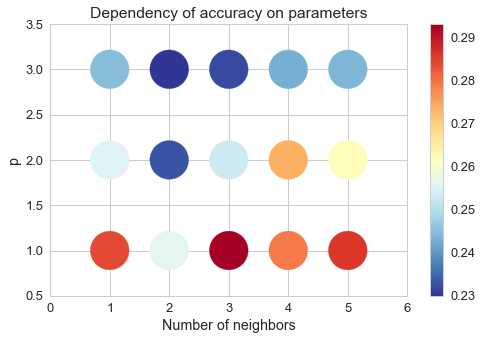

In [110]:
X = boston.data
y = boston.target

In [111]:
# keeping 20% data aside for test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [112]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [113]:
parameters = [{'knn__n_neighbors': list(range(1,6)),
               'knn__p':[1,2],
               'knn__weights':['uniform', 'distance'],
              }]

pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

grid_search = GridSearchCV(pipe, parameters, cv=10, refit=True, verbose=1)
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
0.7968567877596962
Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=1,
          weights='distance'))])


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.6s finished


In [114]:
grid_search.grid_scores_

C:\Users\hv158\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.69306, std: 0.23936, params: {'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'uniform'},
 mean: 0.69306, std: 0.23936, params: {'knn__n_neighbors': 1, 'knn__p': 1, 'knn__weights': 'distance'},
 mean: 0.72512, std: 0.18328, params: {'knn__n_neighbors': 1, 'knn__p': 2, 'knn__weights': 'uniform'},
 mean: 0.72512, std: 0.18328, params: {'knn__n_neighbors': 1, 'knn__p': 2, 'knn__weights': 'distance'},
 mean: 0.75597, std: 0.18189, params: {'knn__n_neighbors': 2, 'knn__p': 1, 'knn__weights': 'uniform'},
 mean: 0.76547, std: 0.18271, params: {'knn__n_neighbors': 2, 'knn__p': 1, 'knn__weights': 'distance'},
 mean: 0.75877, std: 0.17936, params: {'knn__n_neighbors': 2, 'knn__p': 2, 'knn__weights': 'uniform'},
 mean: 0.76553, std: 0.18334, params: {'knn__n_neighbors': 2, 'knn__p': 2, 'knn__weights': 'distance'},
 mean: 0.78119, std: 0.14592, params: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'uniform'},
 mean: 0.79686, std: 0.14889, params: {'knn__n_neighbors': 3, 'knn__p

C:\Users\hv158\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


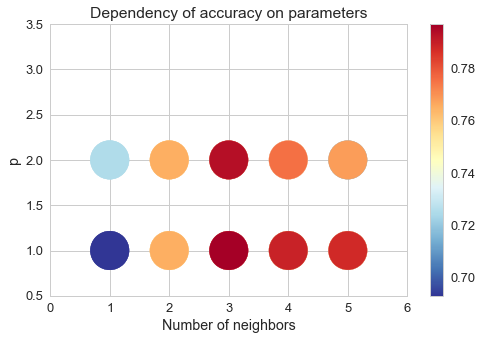

In [115]:
plt.figure(figsize=(8, 5))
sc = plt.scatter(grid_search.cv_results_["param_knn__n_neighbors"], 
                 grid_search.cv_results_["param_knn__p"], 
                 c=grid_search.cv_results_["mean_test_score"], 
                 cmap = plt.get_cmap("RdYlBu_r"), 
                 s=1500)
plt.colorbar(sc)
plt.grid("on")
plt.gca().set_axisbelow(True)
plt.xlabel("Number of neighbors")
plt.ylabel("p")
plt.title("Dependency of accuracy on parameters")
plt.xlim([0, 6])
plt.ylim([0.5, 3.5]);

In [116]:
y_preds = grid_search.best_estimator_.predict(X_test)
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_preds)

17.85040489630077

In [117]:
results.loc[len(results)] = ["KNN Boston", np.round(grid_search.best_score_, 2)]
results

,Model,Test Accuracy
0,KNN Arbitary Sklearn,0.262
1,LR Sklearn,0.338
2,KNN Grid Search Sklearn,0.301
3,KNN Weighted Sklearn,0.304
4,TASK KNN Grid Search Sklearn,0.311
5,KNN Boston,0.800


# Optional Assignment: K Nearest Neighbors from scratch

Implement K Nearest Neighbors classifier from scratch with the Class provided and do experiments on the CIFAR-10 dataset (from Section 4):

* Take the best parameters from section 4.1 
* Train a classifier
* Report a quality and discuss any differences with the SKLearn implemenentation



K Nearest Neighbors classier is the simplest **metric** classifier. The idea behind it is to find $k$ most *similar* objects and make a classification decision based on them.

To formalize the notion of similarity one should introduce the measure of the difference. Here we're going to use $L_p$ norm and induced metric.

$$
d_p(\mathbf{x}_1, \mathbf{x}_2) = \|\mathbf{x}_1 - \mathbf{x}_2\|_p = \left( \sum_{j=1}^{m}\left| x_{1, \,j} - x_{2, \,j} \right|^p \right)^{1/p}
$$

There are special names for some of the $L_p$ metrics:
* $p=1$ is Manhattan distance
* $p=2$ is Euclidian distance

For other metrics one can see [here](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html)

Process of learning for KNN classifier is no more than just remembering all the training examples to find the closest one later on. There are smart ways (such as [KD trees](https://en.wikipedia.org/wiki/K-d_tree)) of storing training objects to be able to find nearest one very fast (faster than simply scanning through all of them). But here you need to implement it as a simple **array**.

For the prediction the following strategy is used:
* Find $k$ closest examples from train set
* Find the most frequent label among these $k$ closest objects (if there are few labels with the same number of objects than pick any label from those)
* Assign this label to new object

In [ ]:
class KNNHomegrown(object):
    
    def __init__(self, n_neighbors=5, p=2):
        self.n_neighbors = n_neighbors
        self.p = p
        self._train_objects = np.array([])
        self._train_labels = np.array([])
        
    def _metric_func(self, x1, x2):
        """
        Return distance between two objects in Lp metric
        
        Args:
            x1(ndarray): first object
            x2(ndarray): second object
        Return:
            distance(float): Lp distance 
                             between x1 and x2
        """
        
        distance = 0.
        
        #==================================================#
        #               Place your code here               #
        #==================================================#
        
        return distance
    
    def _accuracy(self, y_true, y_pred):
        """
        Return the accuracy error measure
        
        Args:
            y_true(ndarray): true labels
            y_pred(ndarray): predicted labels
        Return:
            acc(float):      accuracy
        """
        
        acc = 0.
        
        #==================================================#
        #               Place your code here               #
        #==================================================#
        
        return acc
    
    def fit(self, X, y):
        """
        Fits the KNN classification model
        
        Args:
            X(ndarray): objects to train on
            y(ndarray): labels for each object
        Return:
            self
        """
        
        self._train_objects = np.array([])
        self._train_labels = np.array([])
        
        #==================================================#
        #               Place your code here               #
        #==================================================#
        
        return self
        
    def _nearest_neighbors(self, X):
        """
        Get n nearest neighbors for each object in X.
        For each object in X returns the array of n
        closest objects in train set.
        
        Args:
            X(ndarray): objects
        Return:
            nearest_indices(ndarray): array of nearest 
                                      objects indices
        """
        
        nearest_indices = np.zeros(shape=(X.shape[0], 
                                          self.n_neighbors)) - 1
        
        #==================================================#
        #               Place your code here               #
        #            Hint: use self._metric_func           #
        #==================================================#
        
        return nearest_indices
    
    def predict(self, X):
        """
        Predict the label for new objects
        
        Args:
            X(ndarray): objects to predict
        Return:
            y(ndarray): labels for objects
        """
        
        y = np.zeros(shape=(X.shape[0],)) - 1
        
        #==================================================#
        #               Place your code here               #
        #        Hint: use self._nearest_neighbors         #
        #==================================================#
        
        return y
    
    def score(self, X, y):
        """
        Return a dictionary which contains accuracy and Lp
        error metrics
        
        Args:
            X(ndarray):    objects to predict
            y(ndarray):    true labels for objects
        Return:
            metrics(dict): dictionary which contains metrics
        """
        
        y_pred = self.predict(X)
        
        acc = self._accuracy(y, y_pred)
        loss = self._metric_func(y, y_pred)
        
        metrics = {"acc": acc, "loss": loss}
        
        return metrics

In [ ]:
model_knn_homegrown = KNNHomegrown(n_neighbors=3, p=1)

In [ ]:
model_knn_homegrown.fit(X_train, y_train)

In [ ]:
y_pred_test = model_knn_homegrown.predict(X_test)

In [ ]:
acc = accuracy_score(y_test, y_pred_test)

In [ ]:
results.loc[len(results)] = ["KNN Best Homegrown", np.round(acc, 3)]
results

Check that your implementation gives the same result as Sklearn. There is no randomness in this algorithm so the answer should be almost the same.

# Optional Assignment:  K Weighted Nearest Neighbors

## Vanilla KNN using majority voting
For a classification task using KNN, where K > 1, a majority voting can be thought of as the following: let's assign weight $1$ to each of the $K$ neighbors of the test case  and then just sum up the  weights for each class assign the majority class to the label of the test case. In the case of a draw, we can  randomly select a class based upon unform sampling.

## Weight KNN
Rather than assignment a  equal weight of $1$ to each nearest neighbor, let's assume that weight of each object is **inversly proporional** to the distance to test case. It means that the smaller the distance is the more the weight will be $-$ exactly that we want. The classification is done with the same rule $-$ we just sum up weights for each class and choose the class with the largest weight. 

We can follow a similar strategy for KNN Regression.

## Implement a weighted  KNN for classification
Implement a weighted  KNN for classification and report your findings on the CIFAR-10 dataset

In [ ]:
class KNNWeightedHomegrown(KNNHomegrown):
    
    def __init__(self, n_neighbors=5, p=2, weight_mode="uniform"):
        super(KNNWeightedHomegrown, self).__init__(n_neighbors, p)
        
        if weight_mode != "distance":
            weight_mode = "uniform"
        self.weight_mode = weight_mode
        
        if self.weight_mode == "distance":
            self._weight_func = self._inverse_weights
        else:
            self._weight_func = self._uniform_weights
        
    def _inverse_weights(self, distances):
        """
        Generate neighbors weights which are 
        inversly proportional to the distances from
        object to its neighbor.

        Args:
            distances(ndarray): 2D numpy array
                first axes is objects
                second axes is neighbors of object
                in the cell (i; j) there is distance from
                the i^th object to its j^th nearest neighbor
        Return:
            weights(ndarray):   array of weights
        """ 
        
        weights = np.zeros(shape=distances.shape)
        
        #==================================================#
        #               Place your code here               #
        #            Hint: use self._metric_func           #
        #==================================================#
        
        return weights
    
    def _uniform_weights(self, distances):
        """
        Generate neighbors weights which are 
        uniformly distributed.

        Args:
            distances(ndarray): 2D numpy array
                first axes is objects
                second axes is neighbors of object
                in the cell (i; j) there is distance from
                the i^th object to its j^th nearest neighbor
        Return:
            weights(ndarray):   array of weights
        """ 
        
        weights = np.ones(shape=distances.shape)
        
        return weights
        
    def predict(self, X):
        """
        Predict the label for new objects.
        Accounts for neighbors with weights in the
        mode defined in the constructor.
        
        Args:
            X(ndarray): objects to predict
        Return:
            y(ndarray): labels for objects
        """
        
        y = np.zeros(X.shape[0]) - 1
        
        #==================================================#
        #               Place your code here               #
        #        Hint1: use self._nearest_neighbors        #
        #           Hint2: use self._weight_func           #
        #==================================================#
        
        return y

In [ ]:
model_knn_weighted_homegrown = KNNWeightedHomegrown(n_neighbors=3, p=1)

In [ ]:
model_knn_weighted_homegrown.fit(X_train, y_train)

In [ ]:
y_pred_test = model_knn_weighted_homegrown.predict(X_test)

In [ ]:
acc = accuracy_score(y_test, y_pred_test)

In [ ]:
results.loc[len(results)] = ["KNN Weighted Homegrown", np.round(acc, 3)]
results